In [1]:
import sys
import torch
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import dataloader
sys.path.append('Models/Detection/FasterRCNN')

In [2]:
import torchvision

In [3]:
torchvision.__version__

'0.14.1+cu116'

In [4]:
from Models.Detection.FasterRCNN.my_pretrained_faster_rcnn import fasterrcnn_mobilenet_v3_large_320_fpn_COCO
from utils import simple_watcher, PatternProjector, ToxicTargetsGenerator, log, show, draw_bbox_with_tensor
from AdvPatchGenerator import NoiseLikePatch
from Data import imagenet_1k_mini, coco_2017_dev_5k
from Models.Classification.models import resnet_18
from Trainer import AdvPatchTrainer

In [5]:
train_ds, valid_ds = coco_2017_dev_5k(split_rate=[0.8, 0.2])
net2attack = fasterrcnn_mobilenet_v3_large_320_fpn_COCO()
patch_generator = NoiseLikePatch(128, 128)
projector = PatternProjector(mix_rate=0.99, min_luminance=-2.01, luminance_smooth_boundary=0.001)

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [6]:
idx = 0
mean_loss = 0

def loss_manager(loss_dict, f):
    loss = (0.0 * loss_dict['atk_loss_classifier'] + 0.0 * loss_dict['atk_loss_box_reg'] +
            2.0 * loss_dict['atk_loss_objectness'] + 0.0 * loss_dict['atk_loss_rpn_box_reg']) * 2.0 - \
           (0.0 * loss_dict['loss_classifier'] + 0.0 * loss_dict['loss_box_reg'] +
            1.0 * loss_dict['loss_objectness'] + 0.0 * loss_dict['loss_rpn_box_reg']) * 2.0
    #loss = (loss_dict['atk_loss_box_reg'] + loss_dict['atk_loss_objectness'] + loss_dict['atk_loss_rpn_box_reg'])
    log(loss.item(), f=f)


    return loss

In [7]:
# class LossManager:
#     def __init__(self, log_loss_after_iters=10, **loss_weight_dict):
#         self.weight_dict = loss_weight_dict
#         self.log_loss_after_iters = log_loss_after_iters
#         self.iters_count = 0
#         self.mean_loss = 0
#     def __call__(self, loss_dict, log_file=None):
#         weighted_loss = {}
#         for key in self.weight_dict.keys():
#             weighted_loss[key] = self.weight_dict[key] * loss_dict[key]
#         loss = sum(weighted_loss.values())
#
#         self.mean_loss += loss.item()
#         self.iters_count += 1
#         if (self.iters_count + 1) % self.log_loss_after_iters == 0:
#             log(self.mean_loss / self.log_loss_after_iters, f=log_file)
#             self.mean_loss = 0
#
#         return  loss
#
# loss_weight = {
#     'atk_loss_classifier': 0.0,
#     'atk_loss_box_reg': 0.0,
#     'atk_loss_objectness': 1.0,
#     'atk_loss_rpn_box_reg': 0.0,
#     'loss_classifier': - 0.0,
#     'loss_box_reg': - 0.0,
#     'loss_objectness': - 1.0,
#     'loss_rpn_box_reg': - 0.0,
# }

In [8]:
# loss_func = LossManager(**loss_weight)
loss_func = loss_manager
optimizer = torch.optim.Adam(patch_generator.parameters(), lr=0.1)
targets_generator = ToxicTargetsGenerator()
trainer = AdvPatchTrainer(net2attack,
                          patch_generator,
                          projector,
                          loss_func,
                          optimizer,
                          targets_generator=targets_generator)

In [9]:
datas = []
def watcher(data, f):
    # log(data, f)
    datas.append(data)

trainer.train('Detection', train_ds, 8, 1, valid_ds, "./detect_log_5_22.txt", 4, train_watcher=watcher)

(0.21830470860004425,)
(0.1296864002943039,)
(0.10143191367387772,)
(0.16887620091438293,)
(0.23310190439224243,)
(0.1652420163154602,)
(0.1685274839401245,)
(0.11502408236265182,)
(0.23306280374526978,)
(0.14612802863121033,)
(0.39910227060317993,)
(0.6120089292526245,)
(0.3735322654247284,)
(0.18479643762111664,)
(0.10096579790115356,)
(0.06613495945930481,)
(0.1733580231666565,)
(0.07742753624916077,)
(0.2291317582130432,)
(0.0818895548582077,)
(0.21728071570396423,)
(0.05970032513141632,)
(0.12854206562042236,)
(0.16326501965522766,)
(0.1739000678062439,)
(0.21573936939239502,)
(0.1305273175239563,)
(0.10787353664636612,)
(0.3516498804092407,)
(0.23178519308567047,)
(0.31552982330322266,)
(0.1551072597503662,)
(0.17625592648983002,)
(0.11445431411266327,)
(0.3629382848739624,)
(0.6739764213562012,)
(0.1490011066198349,)
(0.18473942577838898,)
(0.22208784520626068,)
(0.41411906480789185,)
(0.2738878130912781,)
(0.09129513800144196,)
(0.21315397322177887,)
(0.3000321388244629,)
(0.52

KeyboardInterrupt: 

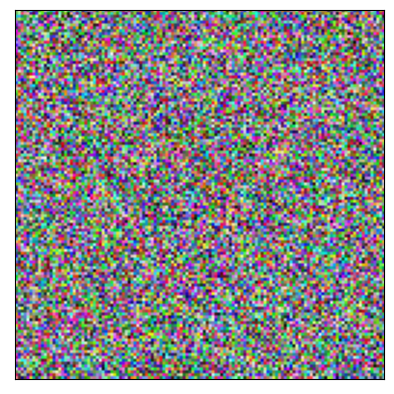

In [10]:
show(make_grid(patch_generator()))

In [26]:
i = 4
net2attack.eval()
img = train_ds[i][0].to('cuda').unsqueeze(0)
img_with_patch = projector(train_ds[i][0].to('cuda'), patch_generator().to('cuda'))[0].unsqueeze(0)

bbox = net2attack(img)[0]['boxes']
bbox_with_patch = net2attack(img_with_patch)[0]['boxes']

pic = draw_bbox_with_tensor(img[0], bbox)
adv_pic = draw_bbox_with_tensor(img_with_patch[0], bbox_with_patch)

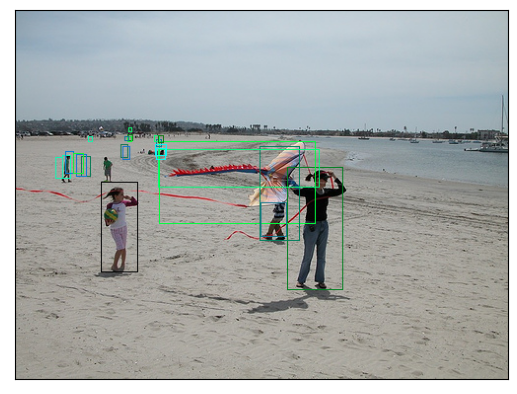

In [27]:
show(make_grid(pic))

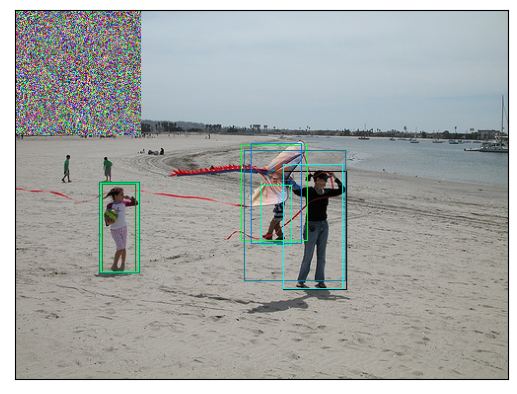

In [28]:
show(make_grid(adv_pic))

In [157]:
net2attack(img_with_patch)[0]

{'boxes': tensor([[412.4050, 227.8044, 449.8395, 298.1907],
         [555.3122, 222.4261, 585.2745, 263.6123],
         [503.1322, 222.1316, 534.0246, 279.7540],
         [565.8817, 225.2980, 595.3791, 256.2181],
         [590.6724, 215.4238, 614.3350, 254.0202],
         [490.7140, 276.2481, 528.0119, 284.2581],
         [481.2292, 229.0901, 501.2396, 260.0835],
         [495.2322, 224.4182, 516.9116, 277.2463],
         [565.9476, 221.3986, 583.4158, 252.5487],
         [474.1367, 225.4398, 497.7969, 269.8109],
         [477.7367, 223.3738, 488.0472, 241.1278],
         [588.8477, 227.2863, 605.4628, 255.7053],
         [490.3787, 276.2657, 528.2788, 284.3235],
         [572.3922, 219.3063, 588.8773, 249.7003],
         [595.5986, 212.8614, 612.2818, 243.7918],
         [476.8908, 230.2084, 494.1429, 256.0208],
         [603.5750, 220.3711, 615.4124, 251.6500],
         [558.4670, 264.6500, 578.9312, 279.1290],
         [473.5916, 225.3682, 485.5567, 242.4591],
         [466.4165, 22